# Création des features avec des données transactionnelles et temporelles.
Dans ce repo, nous avons discuté de plusieurs techniques d'ingénierie de caractéristiques que nous pouvons utiliser pour concevoir des variables dans des données tabulaires, où chaque observation est indépendante et n'affiche qu'une valeur pour chaque variable disponible. Cependant, les données peuvent également contenir plusieurs valeurs qui ne sont pas indépendantes pour chaque entité. Par exemple, il peut y avoir plusieurs enregistrements pour chaque client avec les détails des transactions au sein de notre organisation, telles que les achats, les paiements, les réclamations, les dépôts et les retraits. Dans d'autres cas, les valeurs des variables peuvent changer quotidiennement, comme les cours des actions ou la consommation d'énergie. Les premières sources de données sont appelées données transactionnelles, tandis que les secondes sources de données sont des séries temporelles. Les séries temporelles et les données transactionnelles contiennent des observations horodatées, ce qui signifie qu'elles partagent une dimension temporelle.

Nous créons souvent des fonctionnalités qui agrègent ou résument les informations à partir des points de données historiques des séries chronologiques ou des transactions. Par exemple, nous pouvons créer des fonctionnalités qui capturent le montant maximum dépensé par le client au cours de la semaine dernière, le nombre de transactions qu'il a effectuées ou le temps entre les transactions. Le nombre de fonctionnalités que nous pouvons créer et les manières dont nous pouvons agréger ces informations sont énormes. Dans cet article, nous discuterons des manières les plus courantes de créer des vues agrégées de données historiques à l'aide de pandas. Ensuite, nous ferons une plongée peu profonde dans Featuretools, une bibliothèque conçue pour automatiser la création de fonctionnalités à partir de données transactionnelles. Enfin, nous vous indiquerons d'autres bibliothèques Python conçues spécifiquement pour analyser la complexité du signal.


Dans ce chapitre, nous aborderons les recettes suivantes :

* Agréger des transactions avec des opérations mathématiques
* Agréger des transactions dans une fenêtre temporelle
* Détermination du nombre de maxima et de minima locaux
* Dérivation du temps écoulé entre les événements horodatés
* Création d'entités à partir de transactions avec Featuretools

Nous utiliserons les bibliothèques Python pandas, NumPy, SciPy et Matplotlib, qui peuvent toutes être installées à l'aide de la distribution gratuite Anaconda Python.

Nous utiliserons également la bibliothèque Python open source Featuretools, qui peut être installée à l'aide de pip ou conda.

Tout au long des recettes, nous travaillerons avec un jeu de données de transaction client fictif fourni avec Featuretools et le jeu de données de prévision énergétique Appliances, disponible dans le référentiel UCI Machine Learning: http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

## Agréger des transactions avec des opérations mathématiques

Auparavant, nous avons mentionné que nous pouvons agréger les informations des points de données historiques en observations uniques telles que le montant maximum dépensé pour une transaction, le nombre total de transactions ou la valeur moyenne de toutes les transactions, pour ne citer que quelques exemples. Ces agrégations sont faites avec des opérations mathématiques de base, telles que le maximum, la moyenne ... Comme vous pouvez le voir, les opérations mathématiques sont un moyen simple mais puissant d'obtenir une vue résumée des données historiques.

Dans cette recette, nous allons créer un ensemble de données aplati en agrégeant plusieurs transactions à l'aide d'opérations mathématiques courantes. Nous utiliserons pandas pour le faire

Dans cette recette, nous utiliserons le jeu de données de transaction client fictif fourni avec Featuretools. Cet ensemble de données contient des informations sur les transactions de cinq clients différents. Ces données contiennent un identifiant unique pour distinguer les clients, un identifiant unique pour chaque transaction, l'heure de la transaction, et le montant de la transaction, c'est-à-dire le montant de l'achat. Nous dériverons des caractéristiques de la variable de montant d'achat en effectuant des opérations mathématiques avec pandas.


Commençons par importer les bibliothèques et préparer le jeu de données

In [ ]:
#!python -m pip install featuretools

In [ ]:

import pandas as pd
import featuretools as ft

In [ ]:
# load data from feature tools

data_dict = ft.demo.load_mock_customer()

In [ ]:

# each table in the dictionaty is a pandas dataframe

type(data_dict["transactions"])

pandas.core.frame.DataFrame

Fusionnons les trois tables différentes de l'ensemble de données fictif de Featuretools dans un cadre de données pandas

In [ ]:
# capture all 3 data tables into a pandas dataframe

data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])

data.shape

(500, 11)

Maintenant, nous allons sélectionner les colonnes qui identifient chaque client unique, chaque transaction unique, l'heure de la transaction et le montant dépensé par transaction

In [ ]:
# select the columns with which we will work in this recipe

cols = ['customer_id',
        'transaction_id',
        'transaction_time',
        'amount'
        ]

data = data[cols]

In [ ]:
# display data

data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [ ]:
print('Number of customers: {}'.format(data['customer_id'].nunique()))
print('Number of transactions: {}'.format(data['transaction_id'].nunique()))

Number of customers: 5
Number of transactions: 500


In [ ]:

# dispay number of transactions per customer
data.groupby('customer_id')['transaction_id'].count()

customer_id
1    126
2     93
3     93
4    109
5     79
Name: transaction_id, dtype: int64

### Aggregation with pandas

Maintenant, nous devons créer une vue unique par client qui résume leur activité d'achat. Pour ce faire, nous supprimerons la dimension temporelle des transactions pour capturer le comportement historique dans différentes variables, obtenant ainsi un vecteur de caractéristiques par client

Commençons par faire une liste des fonctions que nous utiliserons pour résumer les données

In [ ]:
# make a list of the operations we want to perform
operations = ['sum', 'max', 'min', 'mean', 'median', 'std', 'count']

# make a list of the new feature names
feature_names = [
    'total_amount', 'max_amount', 'min_amount', 'mean_amount', 'median_amount',
    'std_amount', 'number of transactions'
]

df = pd.DataFrame()

# capture new features in a pandas dataframe
df[feature_names] = data.groupby('customer_id')['amount'].agg(operations)

df

,total_amount,max_amount,min_amount,mean_amount,median_amount,std_amount,number of transactions
customer_id,,,,,,,
1,9025.62,139.43,5.81,71.631905,69.715,40.442059,126
2,7200.28,146.81,8.73,77.422366,75.960,37.705178,93
3,6236.62,149.15,5.89,67.060430,58.930,43.683296,93
4,8727.68,149.95,5.73,80.070459,81.410,45.068765,109
5,6349.66,149.02,7.55,80.375443,78.870,44.095630,79


### Aggregation with Featuretools

Nous pouvons également agréger les données transactionnelles à l'aide de la bibliothèque Featuretools. Pour ce faire, importons les bibliothèques requises et chargeons le jeu de données, comme nous l'avons fait aux étapes précédente de cette recette. Pour travailler avec Featuretools, nous devons transformer le cadre de données en un ensemble d'entités.Commençons

Créons un ensemble d'entités et donnons-lui un nom représentatif et ajoutons la trame de données à l'ensemble d'entités en indiquant que le transaction_id est l'identifiant de transaction unique et en définissant l'heure de la transaction comme index temporel de l'ensemble d'entités

In [ ]:
# in order for feature tools to work, we need to create
# entity sets

# create and entity set and give it a name
es = ft.EntitySet(id="customer_data")

# add transactions table to the entity set
# basically we pass the entire dataframe indicating
# the transaction_id as unique identifier
# and the transaction time as the time index
# there is one unique timestamp per transaction
es.entity_from_dataframe(entity_id='transactions',
                         dataframe=data[cols],
                         index="transaction_id",
                         time_index='transaction_time')

# display the entity set
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 4]
  Relationships:
    No relationships

Featuretools doit identifier l'index de temps et l'index de transaction unique pour effectuer ses opérations

Pour indiquer que chaque client est lié à certaines transactions au sein de l'ensemble d'entités, nous devons créer une nouvelle entité à l'aide de la méthode normalize_entity(), donner un nom à l'entité - dans ce cas, les clients - et spécifier l'identifiant unique pour les clients

In [ ]:
# now we indicate that within the entity set
# there is another table, with customer data,
# each customer identified with a unique
# customer id

es.normalize_entity(base_entity_id="transactions",
                    new_entity_id="customers",
                    index="customer_id")

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 4]
    customers [Rows: 5, Columns: 2]
  Relationships:
    transactions.customer_id -> customers.customer_id

Pour créer ces fonctionnalités, nous allons utiliser le transformateur dfs() de Featuretools et spécifier l'entité sur laquelle les données doivent être agrégées, c'est-à-dire les clients, puis passer la liste des opérations mathématiques qui doivent être utilisées pour créer les nouvelles fonctionnalités ( nous avons créé une liste avec des opérations mathématiques à l'étape précédente :

In [ ]:
# let's print out the operations we want to perform
# we created this list in cell 9

operations

['sum', 'max', 'min', 'mean', 'median', 'std', 'count']

In [ ]:
# set up the feature creation object
# to aggregate transactions at customer level

feature_matrix, features = ft.dfs(entityset=es,
                                  target_entity="customers",
                                  agg_primitives=operations,
                                  trans_primitives=[],
                                  verbose=True,
                                  )

# display name of created features
features

Built 7 features
Elapsed: 00:00 | Progress: 100%|██████████


[<Feature: COUNT(transactions)>,
 <Feature: MAX(transactions.amount)>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: MEDIAN(transactions.amount)>,
 <Feature: MIN(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: SUM(transactions.amount)>]

In [ ]:
# dataframe with the new features
feature_matrix

,COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MEDIAN(transactions.amount),MIN(transactions.amount),STD(transactions.amount),SUM(transactions.amount)
customer_id,,,,,,,
2,93,146.81,77.422366,75.960,8.73,37.705178,7200.28
5,79,149.02,80.375443,78.870,7.55,44.095630,6349.66
4,109,149.95,80.070459,81.410,5.73,45.068765,8727.68
1,126,139.43,71.631905,69.715,5.81,40.442059,9025.62
3,93,149.15,67.060430,58.930,5.89,43.683296,6236.62


## Agréger des transactions dans une fenêtre temporelle.

Lorsque nous voulons prédire un événement à un moment donné, souvent, les transactions ou les valeurs plus proches de l'événement ont tendance à être plus pertinentes. Ensuite, si nous voulons prédire si un client sera désabonné la semaine prochaine, les informations des dernières semaines ou des derniers mois ont tendance à être plus informatives que les transactions du client au cours des 5 dernières années.

Nous pouvons utiliser des opérations mathématiques pour résumer des données historiques, tout comme nous l'avons fait dans la recette précédente, mais uniquement pour une certaine fenêtre temporelle. De cette façon, nous pouvons créer des fonctionnalités telles que le montant maximum dépensé la semaine dernière ou le nombre de transactions le mois dernier, pour ne citer que quelques exemples. Dans cette recette, nous allons résumer les données de séries temporelles sur des fenêtres temporelles trop discrètes à l'aide de pandas


Dans cette recette, nous utiliserons l'ensemble de données de prévision énergétique des appareils du référentiel UCI MachineLearning. Nous travaillerons avec les variables Appareils et lumières, qui contiennent des enregistrements de l'électricité consommée par les appareils ou les lumières dans un seul ménage à des intervalles de 10 minutes pendant une période de 5 mois.

Commençons par importer les bibliothèques et préparer le jeu de données:


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [34]:

# load the appliances energy prediction data set

cols = ['date', 'Appliances', 'lights']

data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv', usecols=cols)

data.head(10)

,date,Appliances,lights
0,2016-01-11 17:00:00,60,30
1,2016-01-11 17:10:00,60,30
2,2016-01-11 17:20:00,50,30
3,2016-01-11 17:30:00,50,40
4,2016-01-11 17:40:00,60,40
5,2016-01-11 17:50:00,50,40
6,2016-01-11 18:00:00,60,50
7,2016-01-11 18:10:00,60,50
8,2016-01-11 18:20:00,60,40
9,2016-01-11 18:30:00,70,40


In [21]:
data.shape

(19735, 3)

In [22]:

data.dtypes

date          object
Appliances     int64
lights         int64
dtype: object

Text(0, 0.5, 'Number of rows')

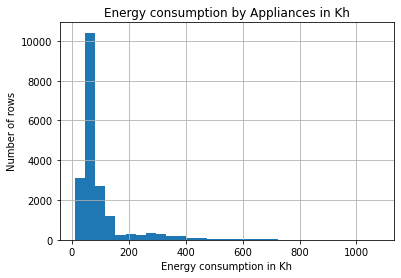

In [23]:
# Make histogram of electirivy consumption by appliances

data['Appliances'].hist(bins=30)
plt.title('Energy consumption by Appliances in Kh')
plt.xlabel('Energy consumption in Kh')
plt.ylabel('Number of rows')

Text(0, 0.5, 'Number of rows')

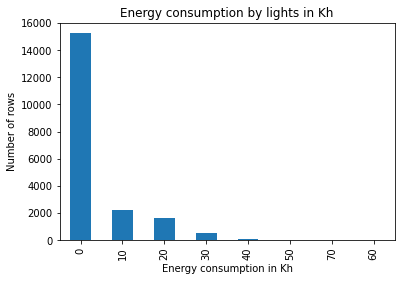

In [24]:
# Make histogram of electirivy consumption by lights

data['lights'].value_counts().plot.bar()
plt.title('Energy consumption by lights in Kh')
plt.xlabel('Energy consumption in Kh')
plt.ylabel('Number of rows')

In [25]:
# check maximun and minimum dates
data['date'].agg(['min', 'max'])

min    2016-01-11 17:00:00
max    2016-05-27 18:00:00
Name: date, dtype: object

Pour le moment, le type de données de la variable date est un objet. Modifions-le pour qu'il s'agisse d'une datetime:

In [35]:
# parse the date column as datetime data type

data['date'] = pd.to_datetime(data['date'])

Text(0.5, 1.0, 'Energy consumption by Appliances in time')

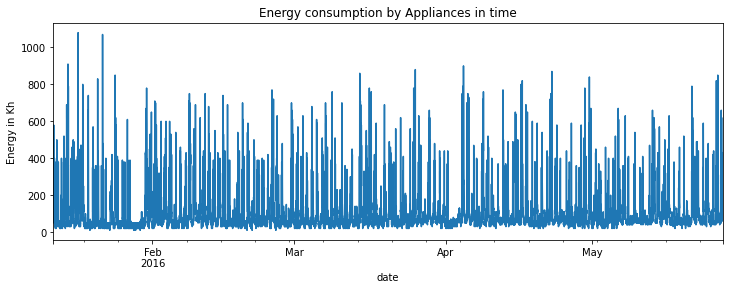

In [27]:
# plot consumption per timepoint by appliances

# I create a copy of the dataframe, not to alter the original dataframe structure
# which s the one I will use in the recipe in the book

tmp = data.copy()
tmp.index = tmp['date']

tmp['Appliances'].plot(figsize=(12, 4))
plt.ylabel('Energy in Kh')
plt.title('Energy consumption by Appliances in time')

Text(0.5, 1.0, 'Energy consumption by lights in time')

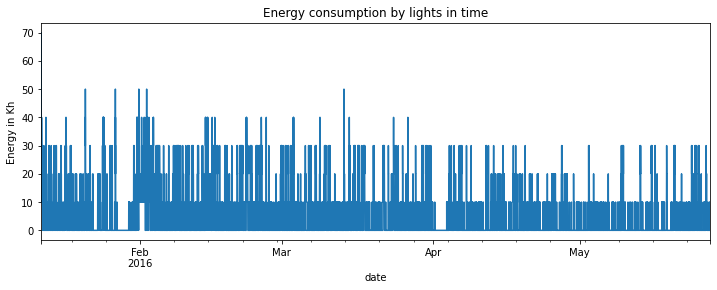

In [28]:
# plot consumption per timepoint by lights

tmp['lights'].plot(figsize=(12,4))
plt.ylabel('Energy in Kh')
plt.title('Energy consumption by lights in time')

### Determine statistical parameters per hr

Créons de nouvelles fonctionnalités qui capturent la consommation d'énergie moyenne des appareils et des lumières au cours des 60 dernières minutes, où six observations couvrent les 60 minutes et l'agrégation est effectuée sur la variable de date. Ensuite, affichons les 10 premières lignes du résultat

#### Single operation

In [29]:
# aggregate the data in 60 min views
# the value displayed by the features represents the average of
# the current and 5 precedent rows of data

data_rolled = data.rolling(window=6, on='date').mean()

data_rolled.head(10)

,date,Appliances,lights
0,2016-01-11 17:00:00,NaN,NaN
1,2016-01-11 17:10:00,NaN,NaN
2,2016-01-11 17:20:00,NaN,NaN
3,2016-01-11 17:30:00,NaN,NaN
4,2016-01-11 17:40:00,NaN,NaN
5,2016-01-11 17:50:00,55.000000,35.000000
6,2016-01-11 18:00:00,55.000000,38.333333
7,2016-01-11 18:10:00,55.000000,41.666667
8,2016-01-11 18:20:00,56.666667,43.333333
9,2016-01-11 18:30:00,60.000000,43.333333


Nous pouvons créer les mêmes fonctionnalités en spécifiant la fenêtre temporelle sous forme de chaîne à la place. Nous pouvons le faire en utilisant data_rolled =data.rolling(window='60min', on='date',min_periods=6).mean()

#### Multiple built-in operations

Nous pouvons accélérer le processus de création de fonctionnalités en agrégeant plusieurs opérations dans chaque fenêtre de temps

In [31]:
# now let's create multiple summaries in for every 60 min window

# make a list of the operations we want to perform
operations = ['sum', 'max', 'min', 'mean', 'median', 'std']

In [32]:
# create a dictionary with the operations to apply to each variable
# in this example we will apply all operations to both variables

op_dict = {key: operations for key in ['Appliances', 'lights']}
op_dict

{'Appliances': ['sum', 'max', 'min', 'mean', 'median', 'std'],
 'lights': ['sum', 'max', 'min', 'mean', 'median', 'std']}

In [38]:
# create the aggregations

data_rolled = data.set_index('date').rolling(window='60min').agg(op_dict)

data_rolled.head(10)

Appliances              ...     lights                 
                           sum   max   min  ...       mean median       std
date                                        ...                            
2016-01-11 17:00:00       60.0  60.0  60.0  ...  30.000000   30.0       NaN
2016-01-11 17:10:00      120.0  60.0  60.0  ...  30.000000   30.0  0.000000
2016-01-11 17:20:00      170.0  60.0  50.0  ...  30.000000   30.0  0.000000
2016-01-11 17:30:00      220.0  60.0  50.0  ...  32.500000   30.0  5.000000
2016-01-11 17:40:00      280.0  60.0  50.0  ...  34.000000   30.0  5.477226
2016-01-11 17:50:00      330.0  60.0  50.0  ...  35.000000   35.0  5.477226
2016-01-11 18:00:00      330.0  60.0  50.0  ...  38.333333   40.0  7.527727
2016-01-11 18:10:00      330.0  60.0  50.0  ...  41.666667   40.0  7.527727
2016-01-11 18:20:00      340.0  60.0  50.0  ...  43.333333   40.0  5.163978
2016-01-11 18:30:00      360.0  70.0  50.0  ...  43.333333   40.0  5.163978

[10 rows x 12 columns]

Notez que chaque observation dans la nouvelle base de données est la moyenne des six observations précédentes. Cela signifie qu'ils ne sont pas indépendants et peuvent être très similaires. Plus les fenêtres temporelles sont grandes, plus les agrégations résultantes ont tendance à être similaires 

#### User defined operations

In [39]:
from scipy.signal import find_peaks

In [40]:
def find_no_peaks(x):
    peaks, _ = find_peaks(x)
    return len(peaks)

def find_no_valleys(x):
    valleys, _ = find_peaks(1/x)
    return len(valleys)

In [41]:

# calculate number of local minima and maxima per day
# ==> more or less 144 time intervals represent 24 hs

data_rolled = data.set_index('date').rolling(window=144).agg([find_no_peaks, find_no_valleys])

## Détermination du nombre de maxima et de minima locaux

Les séries temporelles peuvent être considérées comme un signal, tel qu'un son ou des électrocardiogrammes, et nous pouvons ainsi extraire des caractéristiques qui capturent une partie de la complexité du signal. Des exemples de complexité de signal incluent les valeurs maximales ou moyennes, comme nous en avons discuté dans les recettes précédentes.

Dans cette recette, nous déterminerons manuellement le nombre de maxima et de minima locaux en utilisant le module de signal de SciPy en combinaison avec des pandas. Ensuite, nous vous indiquerons un package Python qui extrait automatiquement ces paramètres et d'autres paramètres complexes de traitement du signal que vous pouvez explorer et utiliser pour étendre votre ensemble d'outils.

Les maxima locaux ou minima locaux, également appelés extrema, sont les valeurs les plus grandes ou les plus petites d'une fonction, soit dans une certaine plage, soit dans l'ensemble du domaine de la fonction. Ils signalent un changement dans la tendance de la fonction. Ici, les maxima locaux viennent après une augmentation et avant une diminution des valeurs de la fonction, alors que les minima locaux viennent après une diminution et avant une augmentation des valeurs de la fonction.

Pour trouver les extrema locaux, nous utiliserons la fonction find_peaks du module de signal de SciPy, qui trouve tous les maxima locaux en effectuant une simple comparaison des valeurs voisines

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [45]:
# load the appliances energy prediction data set

data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [46]:
# check maximun and minimum dates
data['date'].agg(['min', 'max'])

min    2016-01-11 17:00:00
max    2016-05-27 18:00:00
Name: date, dtype: object

In [48]:
# check the data type of the date variable
data['date'].dtypes

dtype('O')

Maintenant, nous devons extraire la partie jour, mois et heure de la variable datetime dans de nouvelles colonnes

In [49]:
# extract datetime derived features

# parse as datetime data type
data['date'] = pd.to_datetime(data['date'])

# new feature names
cols = ['day', 'month', 'hr']

# create the date and time features
data[cols] = pd.DataFrame([(x.day, x.month, x.hour) for x in data['date']])

data[['date', 'Appliances', 'lights'] + cols].head()

,date,Appliances,lights,day,month,hr
0,2016-01-11 17:00:00,60,30,11,1,17
1,2016-01-11 17:10:00,60,30,11,1,17
2,2016-01-11 17:20:00,50,30,11,1,17
3,2016-01-11 17:30:00,50,40,11,1,17
4,2016-01-11 17:40:00,60,40,11,1,17


In [50]:
# inspect month
data['month'].unique()

array([1, 2, 3, 4, 5])

In [51]:
# make the datetime variable the index of the series

data.index = data['date']

Faisons un plot avec l'énergie moyenne consommée par les appareils par heure

Text(0.5, 1.0, 'Daily Cycle of Energy Consumption by Appliances')

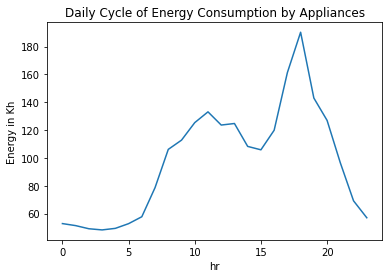

In [52]:
# Explore mean energy consumption by appliances
# per hr of the day throughout the 5 months

data.groupby('hr')['Appliances'].mean().plot()
plt.ylabel('Energy in Kh')
plt.title('Daily Cycle of Energy Consumption by Appliances')

Le graphique suivant montre l'énergie moyenne consommée par heure tout au long de la journée, où la consommation d'énergie de référence tout au long de la nuit est inférieure à 60 Kh

Faisons un graphique de l'énergie moyenne consommée par les appareils par jour tout au long des 5 mois de données que nous avons collectées

Text(0.5, 1.0, 'Mean daily Energy Consumption')

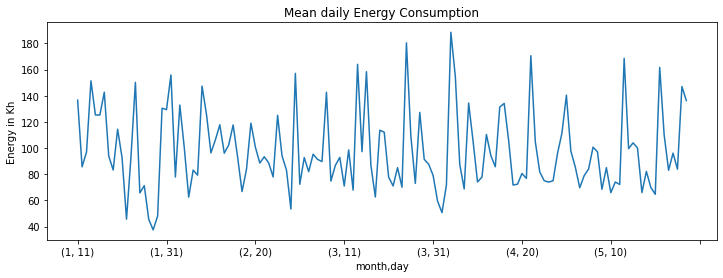

In [53]:
# Plot mean energy consumption by appliances per day
# throughout the 5 months

# we are going to work with this data

data.groupby(['month', 'day'])['Appliances'].mean().plot(figsize=(12, 4))
plt.ylabel('Energy in Kh')
plt.title('Mean daily Energy Consumption')

Dans le graphique suivant, nous pouvons voir qu'il y a plusieurs minima locaux et maxima l'énergie moyenne qui a été consommée par jour dans nos 5 mois d'enregistrements

Créons une série de pandas avec l'énergie moyenne consommée par les appareils électroménagers par jour tout au long des 5 mois

In [54]:
# create a pandas series with the mean energy consumed by appliances
# per day throughout the 5 months

daily_ec = data.groupby(['month', 'day'])['Appliances'].mean()

Déterminons les maxima locaux dans la série chronologique précédente, mais avec la contrainte que les maxima locaux ne peuvent pas afficher des valeurs inférieures à la consommation d'énergie de base de 60 Kh

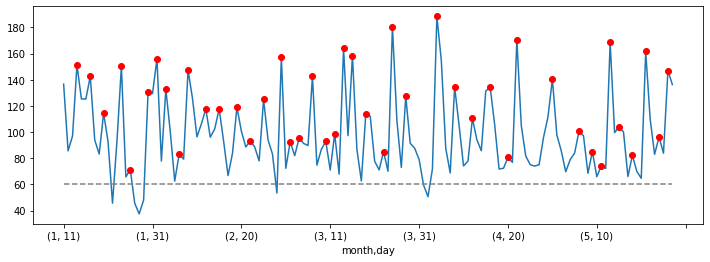

In [55]:
# Determine the days of peak electricity consumption
# throughout the 5 months
# that is, find the local maxima

# find the peaks (local maxima)
# returns an array with the location of the maxima in the pandas
# series
peaks, _ = find_peaks(daily_ec, height=60)

# plot the peaks
#---------------
plt.figure(figsize=(12, 4))

# plot the time series with the mean energy consumed per day
daily_ec.plot()

# Overlay on top of the time series a series of red dots,
# at the location of the local maxima, using the peak variable
# for the x coordinate and the value of the peak for the y coordinate
plt.plot(peaks, daily_ec.values[peaks], "o", color='red')

# add a line at the baseline electricity consumption of 60 Kh
plt.plot(np.full_like(daily_ec, 60), "--", color="gray")

# display the plot
plt.show()

In [56]:
# peaks contains the indeces of the array
# with the days of maximum electricity consumption
peaks

array([  3,   6,   9,  13,  15,  19,  21,  23,  26,  28,  32,  35,  39,
        42,  45,  49,  51,  53,  56,  59,  61,  63,  65,  68,  72,  74,
        77,  84,  88,  92,  96, 100, 102, 110, 116, 119, 121, 123, 125,
       128, 131, 134, 136])

Maintenant, trouvons les minima locaux en utilisant la même fonction et de  l'inverse de la série temporelle

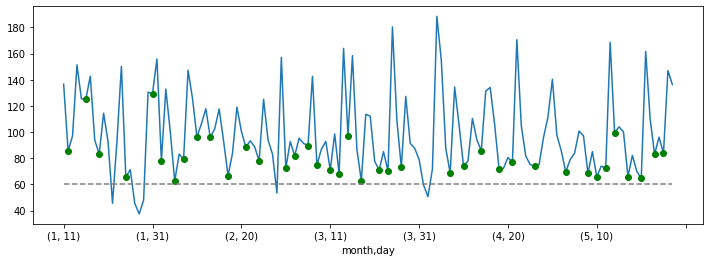

In [58]:
# determine the days of minimum electricity consumption
# throughout the 5 months
# that is, the local minima

# we use the same function, find_peaks, which means that we need to 
# turn the time series upside-dowm, which we do with the reciprocal function
valleys, _ = find_peaks(1 / daily_ec, height=(0, 1/60))

# plot the local minima
plt.figure(figsize=(12, 4))

# plot the time series with the mean energy consumed per day
daily_ec.plot()

# Overlay on top of the time series a series of green dots,
# at the location of the local minima, using the valleys variable
# for the x coordinate and the value of the local minima for the y coordinate
plt.plot(valleys, daily_ec.values[valleys], "o", color='green')

# add a line at the baseline electricity consumption
plt.plot(np.full_like(daily_ec, 60), "--", color="gray")

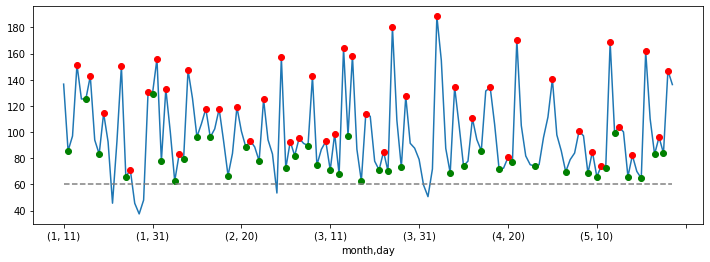

In [62]:
# now, let's determine both local minima and maxima
# and overlay them in a plot

peaks, _ = find_peaks(daily_ec, height=60)
valleys, _ = find_peaks(1 / daily_ec, height=(0, 1/60))

plt.figure(figsize=(12, 4))
daily_ec.plot()
plt.plot(peaks, daily_ec.values[peaks], "o", color='red')
plt.plot(valleys, daily_ec.values[valleys], "o", color='green')
plt.plot(np.full_like(daily_ec, 60), "--", color="gray")
plt.show()

Nous pouvons compter le nombre de maxima et de minima locaux dans une fenêtre temporelle de la série temporelle pour commencer à avoir un aperçu de sa complexité, tout comme nous l'avons fait dans la section Il y a plus dans la recette précédente, Agréger des transactions dans une fenêtre temporelle

#### There is more

Dans cette recette, nous avons identifié les maxima et minima locaux dans une série chronologique pour un seul ménage.Mais comment pourrions-nous déterminer les maxima et minima locaux pour plusieurs maisons ? Nous pouvons combiner l'utilisation de pandas groupby(), pandas agg() et des fonctions définies par l'utilisateur pour atteindre cet objectif. Pour montrer comment procéder, nous utiliserons l'ensemble de données de transactions client de Featuretools. Commençons

In [70]:
import featuretools as ft

# let's load the example data set from feature tools
data_dict = ft.demo.load_mock_customer()

data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])

cols = ['customer_id',
        'transaction_id',
        'transaction_time',
        'amount',
        ]

data = data[cols]

data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [64]:
data['transaction_time'].agg(['min', 'max'])

min   2014-01-01 00:00:00
max   2014-01-01 09:00:35
Name: transaction_time, dtype: datetime64[ns]

In [65]:
data['transaction_time'].dtypes

dtype('<M8[ns]')

In [71]:
# let's create a feature with the hour of the transaction

data['hr'] = data['transaction_time'].dt.hour

data.head()

,customer_id,transaction_id,transaction_time,amount,hr
0,2,298,2014-01-01 00:00:00,127.64,0
1,2,2,2014-01-01 00:01:05,109.48,0
2,2,308,2014-01-01 00:02:10,95.06,0
3,2,116,2014-01-01 00:03:15,78.92,0
4,2,371,2014-01-01 00:04:20,31.54,0


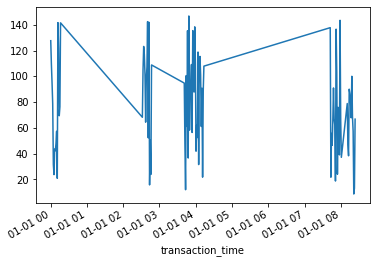

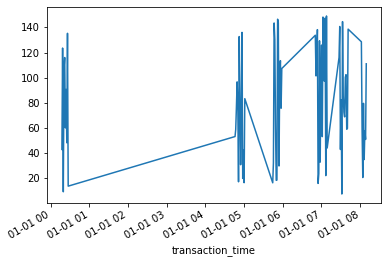

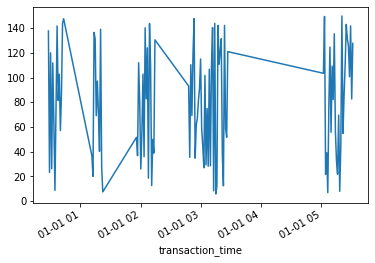

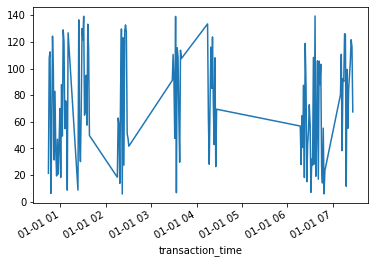

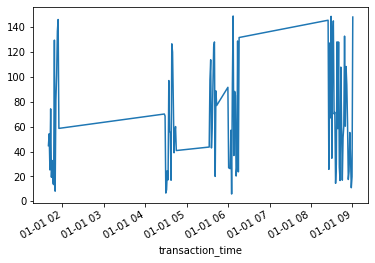

In [67]:
# let's plot the amount per transaction ==>
# one plot per customer
# this step is not in the book

for customer in data['customer_id'].unique():

    # make a small df with one customer
    tmp = data[data['customer_id'] == customer]

    # add the transaction time as index
    tmp.index = tmp['transaction_time']

    # plot the amount spent in time
    tmp['amount'].plot()
    plt.show()

In [72]:
# let's create a function that finds a plots
# the local maxima of a customer amount spent
# per transaction time series

# this function and following cell are not in the book

# x is a pandas series
def find_and_plot_peaks(x, customer):

    # find local maxima
    peaks, _ = find_peaks(x)

    # plot the peaks
    plt.figure(figsize=(4, 3))
    plt.plot(x.values)
    plt.plot(peaks, x.values[peaks], "x")
    plt.title('Customer number {}'.format(customer))
    plt.show()

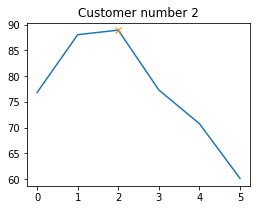

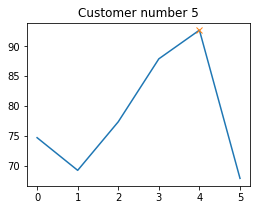

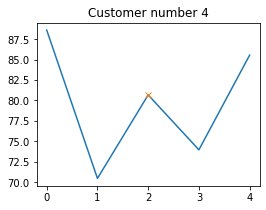

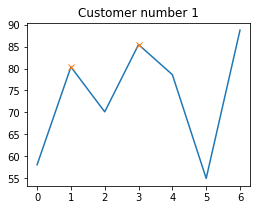

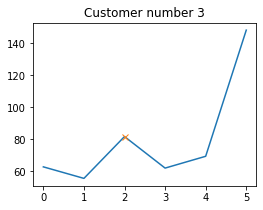

In [73]:
# now let's plot the local maxima for the time series with 
# the mean amount spent per hour ==>

# one plot per customer

# this code is intended to get the reader familiar with the data
# and therefore facilitate the understanding of the recipe code

for customer in data['customer_id'].unique():
    
    # small df with a single customer data
    tmp = data[data['customer_id']==customer]
    
    # aggregate the mean amount spent per hr
    tmp = tmp.groupby('hr')['amount'].mean()
    pd.DataFrame(tmp).reset_index(inplace=True, drop=False)
    
    # find and plot the local maxima
    find_and_plot_peaks(tmp, customer)

In [74]:

# create functions that take a time series
# and return number of local maxima or local minima


def find_no_peaks(x):
    peaks, _ = find_peaks(x)
    return len(peaks)


def find_no_valleys(x):
    valleys, _ = find_peaks(1/x)
    return len(valleys)

In [75]:
# select a single customer data to test function

tmp = data[data['customer_id'] == 3]
tmp = tmp.groupby('hr')['amount'].mean()
tmp

hr
1     62.791333
4     55.579412
5     81.747500
6     62.019333
8     69.403939
9    148.310000
Name: amount, dtype: float64

In [76]:
# test local maxima function

find_no_peaks(tmp)

1

In [77]:

# test local minima function

find_no_valleys(tmp)

2

In [78]:
# find both local maxima and minima in all customers

data.groupby(['customer_id', 'hr'])['amount'].mean().groupby(
    'customer_id').agg([find_no_peaks, find_no_valleys])

,find_no_peaks,find_no_valleys
customer_id,,
1,2,2
2,1,0
3,1,2
4,1,2
5,1,1


## Dérivation du temps écoulé entre les événements horodatés

Dans les recettes précédentes, nous avons effectué des opérations mathématiques sur les valeurs de la série temporelle pour obtenir de nouvelles fonctionnalités qui résument les informations sur la variable, telles que les valeurs moyennes et maximales ou la somme cumulée. Il est également possible d'effectuer ces opérations mathématiques sur l'horodatage et d'obtenir des informations sur le temps entre les transactions ou le temps entre des événements spécifiques.

Dans cette recette, nous allons calculer le temps entre les transactions, c'est-à-dire le temps entre les enregistrements successifs des valeurs des variables. Ensuite, nous déterminerons le temps entre des événements spécifiques, tels que le temps entre les pics de consommation d'énergie, pour démontrer la puissance des pandas lorsqu'il s'agit d'agréger des données de séries chronologiques

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [80]:
# load the appliances energy prediction data set

data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [81]:
# parse as datetime data type

data['date'] = pd.to_datetime(data['date'])

Tout d'abord, calculons le temps entre les transactions, c'est-à-dire le temps entre chaque enregistrement d'énergie, exprimé en minutes

In [82]:
# determine time between transactions, in this case, energy records

data['time_since_previous'] = data['date'].diff()

data['time_since_previous'] = data['time_since_previous']/np.timedelta64(1,'m')

data[['date', 'time_since_previous']].head(10)

,date,time_since_previous
0,2016-01-11 17:00:00,NaN
1,2016-01-11 17:10:00,10.0
2,2016-01-11 17:20:00,10.0
3,2016-01-11 17:30:00,10.0
4,2016-01-11 17:40:00,10.0
5,2016-01-11 17:50:00,10.0
6,2016-01-11 18:00:00,10.0
7,2016-01-11 18:10:00,10.0
8,2016-01-11 18:20:00,10.0
9,2016-01-11 18:30:00,10.0



Une fois que nous avons créé la variable qui capture le temps écoulé depuis les transactions précédentes, nous pouvons utiliser les opérations mathématiques que nous avons utilisées dans la recette d'agrégation de transactions avec des opérations mathématiques au début de ce chapitre pour créer de nouvelles fonctionnalités à partir de celle-ci.

Dans la partie restante de cette recette, nous déterminerons le temps entre les événements spécifiques - dans ce cas, le temps entre les maxima locaux dans l'énergie moyenne journalière consommée par les appareils

In [83]:
# extract day and month from datetime variable

data[['day', 'month']] = pd.DataFrame([(x.day, x.month) for x in data['date']])

data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,time_since_previous,day,month
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,NaN,11,1
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,10.0,11,1
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,10.0,11,1
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,10.0,11,1
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,10.0,11,1


In [84]:
# make the datetime variable the index of the series

data.index = data['date']

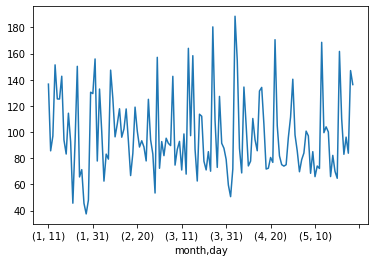

In [85]:
# Plot mean energy consumption by appliances per day
# we are going to work with this data

data.groupby(['month', 'day'])['Appliances'].mean().plot()

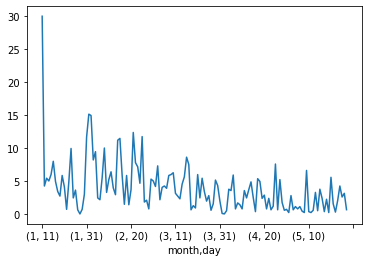

In [86]:
# Plot mean energy consumption by lights per day
# we are going to work with this data

data.groupby(['month', 'day'])['lights'].mean().plot()

In [97]:
# create pandas series with the mean energy consumption per day

# electricity consumption by appliances per day
elec_pday = data.groupby(['month', 'day'])['Appliances'].mean()

# light energy consumption per day
light_pday = data.groupby(['month', 'day'])['lights'].mean()

In [98]:
# find the peaks, that is, the local maxima

peaks, _ = find_peaks(elec_pday.values, height=60)

peaks

array([  3,   6,   9,  13,  15,  19,  21,  23,  26,  28,  32,  35,  39,
        42,  45,  49,  51,  53,  56,  59,  61,  63,  65,  68,  72,  74,
        77,  84,  88,  92,  96, 100, 102, 110, 116, 119, 121, 123, 125,
       128, 131, 134, 136])

In [124]:
# compare the shape of the time series with that of the selected
# local maxima series

elec_pday.shape, len(elec_pday.values[peaks])

((138,), 43)

In [157]:
idx = pd.IndexSlice

elec_pday.shape, elec_pday.loc[idx[:,peaks]].shape

((138,), (46,))

Maintenant, créons un cadre de données avec uniquement les maxima locaux de la consommation d'énergie moyenne de l'appareil, réinitialisons son index pour créer des colonnes de mois et de jour du cadre de données, et ajoutons une variable avec l'année et affichons les lignes du haut

In [158]:

# capture the series with local maxima in a pandas dataframe
# then reset index so that the month and day become part of the columns

# finally, we need to add the year, to be able to reconstitute the date
# from the existing time columns

tmp = pd.DataFrame(elec_pday.loc[idx[:,peaks]]).reset_index(drop=False)
tmp['year'] = 2016
tmp.head()

,month,day,Appliances,year
0,1,13,97.013889,2016
1,1,15,125.347222,2016
2,1,19,83.263889,2016
3,1,21,92.638889,2016
4,1,23,93.055556,2016


In [159]:
# reconstitute the datetime variable

tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])

tmp.head()

,month,day,Appliances,year,date
0,1,13,97.013889,2016,2016-01-13
1,1,15,125.347222,2016,2016-01-15
2,1,19,83.263889,2016,2016-01-19
3,1,21,92.638889,2016,2016-01-21
4,1,23,93.055556,2016,2016-01-23


Pour déterminer la distance en jours entre les maxima locaux, nous devons déterminer la distance entre les lignes, car chaque ligne de la trame de données précédente contient un maximum local

In [160]:
# calculate the distance, in days, between the local maxima
# we do this utilizing the dataframe with only the local maxima

tmp['peak_distance'] = tmp['date'].diff()

tmp['peak_distance'] = tmp['peak_distance'].dt.days

tmp.head()

,month,day,Appliances,year,date,peak_distance
0,1,13,97.013889,2016,2016-01-13,NaN
1,1,15,125.347222,2016,2016-01-15,2.0
2,1,19,83.263889,2016,2016-01-19,4.0
3,1,21,92.638889,2016,2016-01-21,2.0
4,1,23,93.055556,2016,2016-01-23,2.0


In [ ]:
# now we put all the steps together in a function

# not in book, but useful information for readers, to
# automate the calculation of peak distances across variables

def time_between_peaks(ser):

    # find local maxima
    peaks, _ = find_peaks(ser.values)

    # select the series values with local maxima only
    # transform the series into a dataframe with the month
    # and day index as columns
    tmp = pd.DataFrame(ser[peaks]).reset_index(drop=False)

    # add year to reconstitute date
    tmp['year'] = 2016

    # reconstitute date
    tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])

    # calculate difference in days between local maxima
    tmp['peak_distance'] = tmp['date'].diff()
    tmp['peak_distance'] = tmp['peak_distance'].dt.days

    # return difference in days between local maxima
    # that is a pandas series
    return tmp['peak_distance']

#### To determine distance between local maxima and minima

Nous pouvons déterminer la valeur moyenne du temps entre les maxima et minima locaux pour plus d'une entité. Pour montrer comment automatiser cette procédure, nous utiliserons l'ensemble de données de transaction client themock de Featuretools. Commençons

In [162]:
# determine the days of minimum electricity consumption 
# throughout the 5 months, that is the local minima

# we use peak values but we turn the series upside down with the
# reciprocal function

valleys, _ = find_peaks(1 / elec_pday.values, height=(-np.Inf, 1/60))
valleys

array([  1,   5,   8,  14,  20,  22,  25,  27,  30,  33,  37,  41,  44,
        50,  52,  55,  57,  60,  62,  64,  67,  71,  73,  76,  87,  90,
        94,  98, 101, 106, 113, 118, 120, 122, 124, 127, 130, 133, 135])

In [168]:

# compare the number of observations in the entire series
# vs the number of local maxima, vs the number of local minima

elec_pday.shape, elec_pday.loc[idx[:,peaks]].shape , elec_pday.loc[idx[:,valleys]].shape

((138,), (46,), (40,))

In [169]:

# concatenate the indices that contain the local minima and maxima
# and then sort its values

peaksandvalleys = np.concatenate([peaks, valleys])
peaksandvalleys.sort()
peaksandvalleys

array([  1,   3,   5,   6,   8,   9,  13,  14,  15,  19,  20,  21,  22,
        23,  25,  26,  27,  28,  30,  32,  33,  35,  37,  39,  41,  42,
        44,  45,  49,  50,  51,  52,  53,  55,  56,  57,  59,  60,  61,
        62,  63,  64,  65,  67,  68,  71,  72,  73,  74,  76,  77,  84,
        87,  88,  90,  92,  94,  96,  98, 100, 101, 102, 106, 110, 113,
       116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131,
       133, 134, 135, 136])

In [172]:

# now we use this index to select the data

elec_pday.loc[idx[:,peaksandvalleys]].shape

(86,)

Pour déterminer le temps écoulé entre les maxima et les minima locaux, nous devons créer un cadre de données avec ces valeurs exécutant :

tmp = pd.DataFrame(elec_pday[peaksandvalleys]).reset_index(drop=False)

puis, 1) ajouter l'année, 2) reconstituer la date, et 3) calculer le temps entre les maxima et minima locaux, comme nous l'avons fait dans les cellules précédentes.